In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
#データを取得する
#取得データをDataFrameにする
X_original = pd.DataFrame(load_boston().data,columns=load_boston().feature_names)
y = pd.DataFrame(load_boston().target)
y.columns = ['MEDV']


#基本的なデータ探索について記述せよ
このデータセットは何のデータセットであるか(何のために作成されたか、誰が作成したか、何年に作成されたか)    
→米国ボストン市郊外における地域別の住宅価格のデータセット  
ボストンの郊外地域に関する犯罪率やその他様々な属性から、価格を見積もるためのデータ  
１９７０年のアメリカの国勢調査によるもの  
  
それぞれのカラムは何を表しているのか  
→  
CRIM→人口1人当たりの犯罪発生数  
ZN→25,000 平方フィート以上の住居区画の占める割合  
INDUS→小売業以外の商業が占める面積の割合  
CHAS→チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外)  
NOX→NOx の濃度  
RM→住居の平均部屋数  
AGE→1940 年より前に建てられた物件の割合  
DIS→5 つのボストン市の雇用施設からの距離 (重み付け済)  
RAD→環状高速道路へのアクセスしやすさ  
TAX→$10000 ドルあたりの不動産税率の総計  
PTRATIO→町毎の児童と教師の比率  
B→町毎の黒人 (Bk) の比率を次の式で表したもの。 1000(Bk – 0.63)^2  
LSTAT→給与の低い職業に従事する人口の割合 (%)  
    

In [23]:
X_original.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [24]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


#describeメソッドを用いることで把握できたこと(考察)を記述せよ  
  
前処理に関して気をつけるべき点  
→ 前処理は時間をかけすぎない。どのモデルを使うかという事を事前に考慮し、どのデータが必要かなどを吟味する。  
  
機械学習の手法選択に活かせること、機械学習の特徴選択について考えられること  
→データ数が少ないと思われる場合は、過学習しないような手法を選択する  
欠損値が多いか。  
欠損値が多い場合はそれでも有効な手法を選ぶ。  
   

In [25]:
#二変数の可視化
boston_data = pd.concat([X_original,y],axis=1 )
pd.DataFrame.corr(boston_data)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,0.288250,-0.377365,0.452220,-0.385832
ZN,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.579564,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


#二変数の可視化について記述せよ  
  
そもそも相関とは何か  
→２つの変量の間に，一方が増加すれば他方も増加する、または一方が増加すれば他方が減少するという関係  
  
MEDVにもっとも相関があると出力された変数を3つほどあげよ。  
→LSTAT,RM,PTRATIO  
  
相関がある変数を判明させることでどのように利用できそうか考察せよ（調査せよ）  
→相関がある変数を説明変数として残し、それ以外の変数を一度省いてまずは解析を進めてみる。結果次第で説明変数を増やしたり減らしたりする。  

#相関の注意点について記述せよ  
  
相関が正しく2変数の関係を表していない時がある、それはどのような場合か  
→外れ値が存在する場合  
  
その場合、どのような手段によって、確認するべきか  
→散布図を出して目視で外れ値を確認し、アナログに取り除く。  

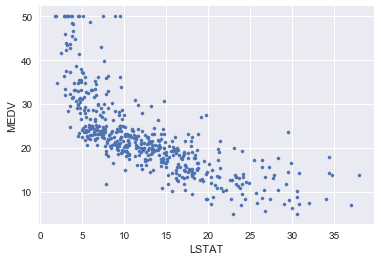

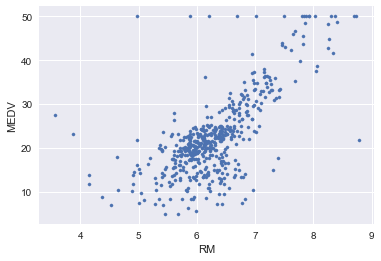

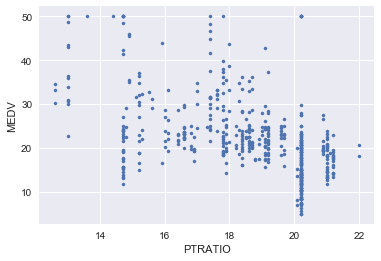

In [26]:
plt.scatter(X_original["LSTAT"],y,s=10)
plt.xlabel("LSTAT")
plt.ylabel("MEDV")
plt.show()

plt.scatter(X_original["RM"],y,s=10)
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.show()

plt.scatter(X_original["PTRATIO"],y,s=10)
plt.xlabel("PTRATIO")
plt.ylabel("MEDV")
plt.show()

#二変数の可視化について記述せよ  
  
それぞれのプロット結果から、今回の相関はそれぞれ信用できるか記述せよ。  
→PTRATIOはデータが離散的であり、相関については信用できない。  

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_original[["LSTAT","RM","PTRATIO"]],y["MEDV"],test_size=0.2,random_state=0)

In [113]:
#学習
#決定係数

from sklearn.tree import DecisionTreeRegressor

regressor1 = DecisionTreeRegressor(max_depth=1)
regressor2 = DecisionTreeRegressor(max_depth=2)
regressor3 = DecisionTreeRegressor(max_depth=3)

regressor1.fit(X_train,y_train)
regressor2.fit(X_train,y_train)
regressor3.fit(X_train,y_train)

print("深さ1　の場合の決定係数は{:.2f}".format(regressor1.score(X_test,y_test)))
print("深さ2　の場合の決定係数は{:.2f}".format(regressor2.score(X_test,y_test)))
print("深さ3　の場合の決定係数は{:.2f}".format(regressor3.score(X_test,y_test)))

深さ1　の場合の決定係数は0.25
深さ2　の場合の決定係数は0.57
深さ3　の場合の決定係数は0.59


In [102]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    


Automatically created module for IPython interactive environment


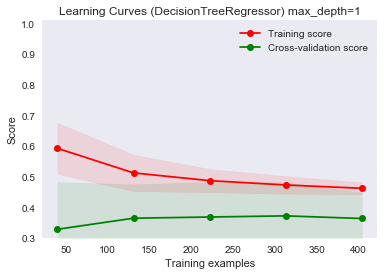

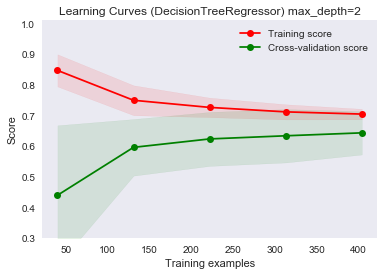

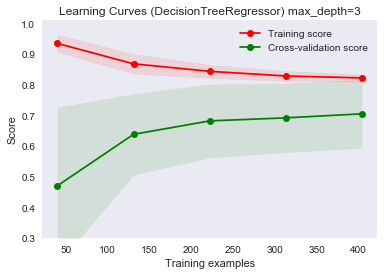

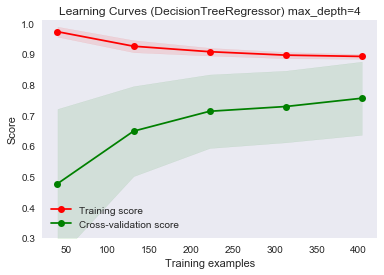

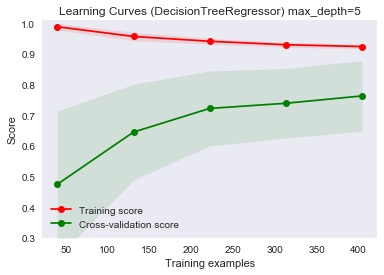

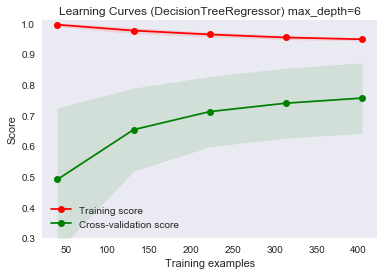

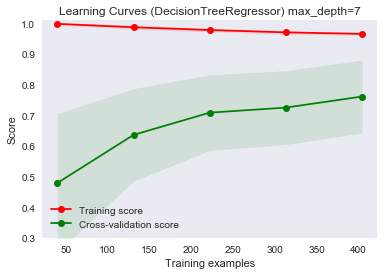

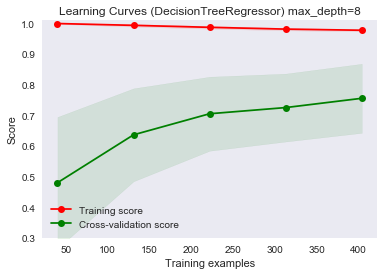

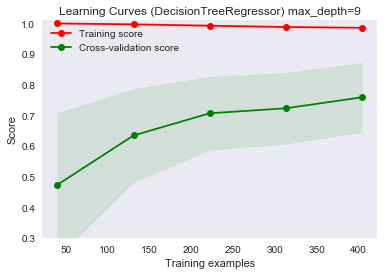

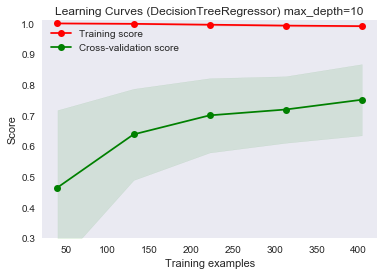

In [103]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor

title = "Learning Curves (DecisionTreeRegressor) max_depth={}".format(degree)
features = load_boston().data
target = load_boston().target
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

for degree in range(1,11):
    estimator = DecisionTreeRegressor(max_depth=degree)
    plot_learning_curve(estimator, "Learning Curves (DecisionTreeRegressor) max_depth={}".format(degree),features , target, ylim=(0.3, 1.01), cv=cv, n_jobs=4)



#学習曲線について記述せよ  
High varianceとは何か  
→学習データに対して性能が良いが、テストデータに対しては精度が高くない状態  
  
High Biasとは何か  
→学習データに対しての性能は良くはないが、テストデータに対しては精度が安定している状態  
  
もっとも結果が良いと思われた深さをひとつ選択せよ  
→max_depth = ５
  
なぜその深さが最も良いか記述せよ  
→過学習しておらず、cross_validation スコアが高い

その最も結果が良いと思われる深さにおいて、データ数を増やしていくと、さらに結果は良くなるか記述せよ  
→cross_validation　スコアが現状上あがりのため、データ数をふやすと精度は高くなる可能性はある。

In [104]:
from sklearn.metrics import r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

regressor = DecisionTreeRegressor()
params = {"max_depth":  list(range(1,11))}
scoring_fnc=make_scorer(r2_score)
grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc,cv=5)
grid.fit(X_train,y_train)
print(grid.best_params_)

{'max_depth': 5}


#グリッドサーチについて記述せよ  
グリッドサーチとは何か  　　
→ハイパーパラメータの探索空間を格子状 (グリッド) に区切り、交点となるハイパーパラメータの組み合わせについて、すべて調べるという方法。  
  
グリッドサーチと同じようにハイパーパラメーターを探索する手法を挙げよ  
→ベイズ最適化  
  
その手法は、グリッドサーチと比べて、どの点で優れているか、どのように使い分けるべきか  
→グリッドサーチは与えられたハイパーパラメータの値の全ての組み合わせについて計算を行うが、ベイズ最適化は探索の仕方があり、探索があまりなされてない範囲について適度に探索を行い、すでに行った探索の中での最適値をうまく次の探索で使用している。  

In [105]:
#グリッドサーチを使いこなそう

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

regressor = DecisionTreeRegressor()
params = {"max_depth":  list(range(1,11))}
scoring_fnc=make_scorer(mean_squared_error)
grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc,cv=3)
grid.fit(X_train,y_train)
print(grid.best_params_)

{'max_depth': 1}


In [106]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

regressor = DecisionTreeRegressor()
params = {"max_depth":  list(range(1,11))}
scoring_fnc=make_scorer(mean_squared_error)
grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc,cv=10)
grid.fit(X_train,y_train)
print(grid.best_params_)

#??なぜ１になるのか#

{'max_depth': 1}


In [132]:
#テスト
#最後にテストデータを使用して、テストを行いましょう。グリッドサーチによって求めた深さの探索木で、学習を行い、最後に決定係数を求めます。(0.7以上の数値がでていれば合格です。)

#深さを３とする
#X_train, X_test, y_train, y_test = train_test_split(X_original[["LSTAT","RM","PTRATIO"]],y["MEDV"],test_size=0.2,random_state=1)
regressor5 = DecisionTreeRegressor(max_depth=5)

X_train, X_test, y_train, y_test = train_test_split(X_original[["LSTAT","RM","PTRATIO"]],y["MEDV"],test_size=0.2,random_state=1)

regressor5.fit(X_train,y_train)
print("深さ5　の場合の決定係数は{:.2f}".format(regressor5.score(X_test,y_test)))

深さ5　の場合の決定係数は0.71


In [133]:

from sklearn.model_selection import cross_val_score
train_data=X_original[["LSTAT","RM","PTRATIO"]]
test_data=y["MEDV"]

regressor3 = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(regressor3, train_data, test_data, cv=5)
#print("深さ3　の場合の決定係数は{:.2f}".format(scores.mean()))
print(scores)

[ 0.69057116  0.77159882  0.15765964  0.39326444  0.27215732]


深さ5　の場合の決定係数は0.86
